#**Detecting Phishing URLs**

#**What is Phishing Attack?**
Phishing is a cyber attack that uses disguised email as a weapon. The goal is to trick the email recipient into believing that the message is something they 
want or need — a request from their bank, for instance, or a note from someone in their company — and to click a link or download an attachment.

Phishing is a type of social engineering where an attacker sends a fraudulent message designed to trick a human victim into revealing sensitive information to the attacker or to deploy malicious software on the victim's infrastructure like ransomware. Source: Wikipedia

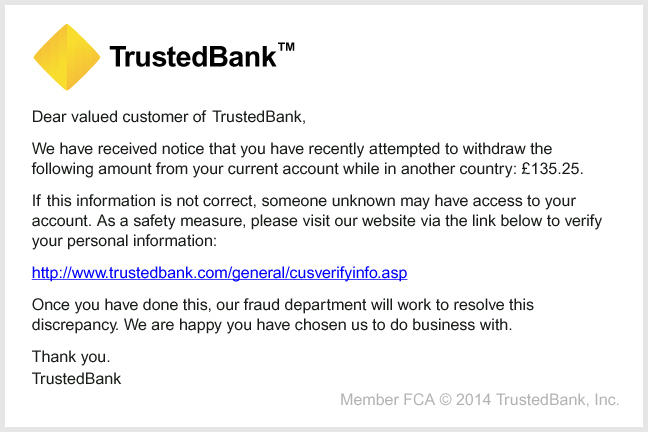


In [ ]:
#updating the scikit learn library version scikit-learn-0.24.2 
#to use HalvingRandomSearchCV for grid search hyperparameters 
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [ ]:
!pip install -U imbalanced-learn


In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
from io import StringIO
import requests
from sklearn.decomposition import TruncatedSVD
import re 
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix
import pickle# use to dump model 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import nltk 
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer
import time # calculate time 
from sklearn.pipeline import make_pipeline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV
import sklearn.neighbors
import numpy as np
import six
import sys
sys.modules['sklearn.externals.six'] = six
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_validate
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from scipy import stats
from scipy.stats import randint

## Reading CSV DataSet 
### My DataSet contains one dependent feature called URL and categorical  independent field data to classify the URL whether *phishing* or not.

In [ ]:
Fileurl='https://drive.google.com/file/d/15K_5CbbKFr-sChFUz0jN-6ZYcMBxgQA5/view?usp=sharing'
file_id=Fileurl.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
phishingDataFrame = pd.read_csv(dwn_url)
phishingDataFrame
phishingDataFrame.head() 

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


#Checking Nan and NULL values

In [ ]:
phishingDataFrame.isna==True, phishingDataFrame.URL.isna==True, phishingDataFrame.Label.isna==True #false

(False, False, False)

#NO NEED TO SCALE X (NO NUMERICAL VALUES)

#Splitting X and y

In [ ]:
#spliting X and Y values
X = phishingDataFrame.iloc[:,:-1].values
y = phishingDataFrame.iloc[:,-1].values


#Steming Words

In [ ]:
#create REGEX
Approved = re.compile(r'[A-Za-z]+')
token = RegexpTokenizer(Approved)

In [ ]:
#checking the length of data frame
len(phishingDataFrame)

549346

In [ ]:
#some items is IP addresses and not URLs (we want to exclude them)
Item549341 = phishingDataFrame.URL[549341]
Item549341

'23.227.196.215/'

In [ ]:
#create empty column for clear NewToken
phishingDataFrame['NewToken']=''

In [ ]:
#apply REGEX
phishingDataFrame['NewToken']=phishingDataFrame.apply(lambda row: token.tokenize(row['URL']), axis=1)

In [ ]:
#check the length  to drop the rows of (0) length which is the IP addresses
phishingDataFrame['LenNewToken']=phishingDataFrame.apply(lambda row: len(row['NewToken']), axis=1)

In [ ]:
#Perform the Drop
phishingDataFrame.drop(phishingDataFrame[phishingDataFrame.LenNewToken == 0].index, inplace=True) #droping data IP addresses

In [ ]:
#checking the length after dropping rows
print(len(phishingDataFrame.URL))
print(len(phishingDataFrame.Label))
print(len(phishingDataFrame))

547537
547537
547537


In [ ]:
#Stemming the Words
stemmer = SnowballStemmer("english") # choose a language
phishingDataFrame['TokenData']=phishingDataFrame['URL'].map(lambda l: [stemmer.stem(word) for word in l])

In [ ]:
phishingDataFrame['text_TokenData'] = phishingDataFrame['NewToken'].map(lambda l: ' '.join(l))

In [ ]:
phishingDataFrame['text_TokenData']

0         nobell it ffb d dca cce f login SkyPe com en c...
1         www dghjdgf com paypal co uk cycgi bin webscrc...
2         serviciosbys com paypal cgi bin get into herf ...
3         mail printakid com www online americanexpress ...
4         thewhiskeydregs com wp content themes widescre...
                                ...                        
549340                          mol com ho me cv itworx doc
549342                                    apple checker org
549343                                     apple iclods org
549344                                    apple uptoday org
549345                                    apple search info
Name: text_TokenData, Length: 547537, dtype: object

#Encode Categorical Data in Y

In [ ]:
#checking Categorical value in y
print(phishingDataFrame['Label'].unique())
print(len(phishingDataFrame['Label']))
le= LabelEncoder()
y = le.fit_transform(phishingDataFrame['Label'])
y
print(len(y))

['bad' 'good']
547537
547537


#Checking Data if it is Imbalanced

In [ ]:
#Y data values counts
phishingDataFrame['Label'].value_counts()

good    392911
bad     154626
Name: Label, dtype: int64

In [ ]:
#Percentage of good values
392924/phishingDataFrame.shape[0]

0.717620909637157

In [ ]:
#Percentage of bad values
156422/phishingDataFrame.shape[0]

0.28568297667554887

#Processing Imbalance Data

In [ ]:
#Processing Imbalance Data
oversample = RandomOverSampler(sampling_strategy='minority')
vectorizer = CountVectorizer()
NewFeature = vectorizer.fit_transform(phishingDataFrame.text_TokenData)
print(NewFeature.shape)
print(y.shape)

X_res, y_res = oversample.fit_resample(NewFeature, y)

print(X_res.shape)
print(y_res.shape)

(547537, 369586)
(547537,)
(785822, 369586)
(785822,)


#Splitting X and Y

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size=0.35, random_state=1000)

**Create first Classifier PassiveAggressiveClassifier**
**[With oversampling and GridSearch to find Hyper Parameters]**

Passive: If the prediction is correct, keep the model and do not make any changes. i.e., the data in the example is not enough to cause any changes in the model. 

Aggressive: If the prediction is incorrect, make changes to the model. i.e., some change to the model may correct it.

If you want to work on **big data**, this is a very important classifier and I encourage you to go ahead and try to build a project using this classifier and use live data from a social media website like Twitter as input. There will be a huge amount of data coming in every second and this classifier will be able to handle data of this size.


In [ ]:
scoring = ["accuracy", "balanced_accuracy"]
gridSearch=True
cvFolds = 5
randomState=1
param_grid = {'C' : [0.003, 0.01, 0.03, 0.1], 'loss': ['hinge', 'squared_hinge'], 'max_iter': [5, 10, 30, 100, 300]}
clf = PassiveAggressiveClassifier(random_state = randomState, loss = 'squared_hinge', max_iter = 100, C = 0.01)
clf.fit(X_train, Y_train)
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 2,
    verbose=True
)
grid_search.fit(X_train,Y_train)
pred = clf.predict(X_test)

print(f"Balanced accuracy score of a Passive Aggressive Classifier with Over sampling : {balanced_accuracy_score(Y_test,pred)}")

Fitting 2 folds for each of 40 candidates, totalling 80 fits
Balanced accuracy score of a Passive Aggressive Classifier with Over sampling : 0.9894509372988385


**XGBoost Classifier [With oversampling and GridSearch to find Hyper Parameters]** :

Is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) ... A wide range of applications: Can be used to solve regression, classification, ranking, and user-defined prediction problems.
since we are dealing with text data and with a classification problem , this could be a good choice for our problem case.

In [ ]:
scoring = ["accuracy", "balanced_accuracy"]
XG = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    verbose=1)

params = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,10,2)
}
grid_search = HalvingRandomSearchCV(estimator=XG, param_distributions=params, scoring='roc_auc', n_jobs=1,cv=2, verbose=True)

grid_search.fit(X_res, y_res)
grid_search.best_estimator_
cv_result = cross_validate(XG, X_res, y_res, scoring = scoring)
print(f"Balanced accuracy score of a XGboost Classifier with Over sampling : {cv_result['test_balanced_accuracy'].mean():0.3f}")

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 11
min_resources_: 8
max_resources_: 785822
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 8
Fitting 2 folds for each of 20 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 7
n_resources: 24
Fitting 2 folds for each of 7 candidates, totalling 14 fits
----------
iter: 2
n_candidates: 3
n_resources: 72
Fitting 2 folds for each of 3 candidates, totalling 6 fits
Balanced accuracy score of a XGboost Classifier with Over sampling : 0.737


**LogisticRegression  Classifier:[With oversampling and GridSearch to find Hyper Parameters]**

Logistic regression is a classification algorithm, used when the value of the target variable is categorical in nature. Logistic regression is most commonly used when the data in question has binary output, so when it belongs to one class or another, or is either a 0 or 1.
in our case the result is either 0 (bad) or 1.



In [ ]:
scoring = ["accuracy", "balanced_accuracy"]
penalty = ['l2']
lr =LogisticRegression(max_iter=200)
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
logreg_cv=HalvingRandomSearchCV(lr,hyperparameters,cv=5)
logreg_cv.fit(X_res,y_res)
cv_result = cross_validate(lr, X_res, y_res, scoring = scoring)
print(f"Balanced accuracy score of a LogisticRegression  Classifier with Over sampling : {cv_result['test_balanced_accuracy'].mean():0.3f}")

Balanced accuracy score of a LogisticRegression  Classifier with Over sampling : 0.936


**Stochastic Gradient Descent Classifier SGD [With oversampling and GridSearch 
to find Hyper Parameters]**:

 is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. Given that the data is sparse, the classifiers in this module easily scale to problems with more than 10^5 training examples and more than 10^5 features

In [ ]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}
scoring = ["accuracy", "balanced_accuracy"]
SGD = SGDClassifier(max_iter=1000)
logreg_cv=HalvingRandomSearchCV(SGD,params,cv=5)
logreg_cv.fit(X_res,y_res)
cv_result = cross_validate(SGD, X_res, y_res, scoring = scoring)
print(f"Balanced accuracy score of a SGD  Classifier with Over sampling : {cv_result['test_balanced_accuracy'].mean():0.3f}")

Balanced accuracy score of a SGD  Classifier with Over sampling : 0.888


In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), PassiveAggressiveClassifier())


In [ ]:
trainX, testX, trainY, testY = train_test_split(phishingDataFrame.URL, phishingDataFrame.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>)),
                ('passiveaggressiveclassifier', PassiveAggressiveClassifier())])

Training Accuracy : 0.9991379562257093
Testing Accuracy : 0.9793476275705885

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.96      0.97      0.96     38264
        Good       0.99      0.98      0.99     98621

    accuracy                           0.98    136885
   macro avg       0.97      0.98      0.97    136885
weighted avg       0.98      0.98      0.98    136885


CONFUSION MATRIX


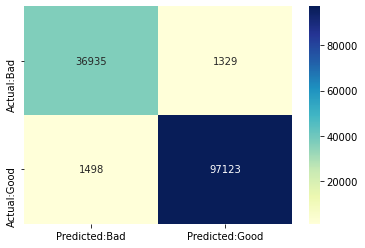

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

##Predicting for shorten URL and Normal URL

In [ ]:
!pip install pyshorteners

In [ ]:
!pip install short_url

In [ ]:
import pyshorteners  as sh
s = sh.Shortener()
s2 = sh.Shortener()
link = 'https://www.youtube.com/ayushirawat/videos11'
print(s.tinyurl.short(link))
link2= 'yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php'

https://tinyurl.com/yznhq464


In [ ]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9938342404207912


In [ ]:
dict_URL = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php',s2.tinyurl.expand('https://tinyurl.com/yznhq464'),'retailhellunderground.com/','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))

result = loaded_model.predict(predict_URL)
print(result)


['bad' 'good' 'good' 'bad']


##Findings


1.   **Balanced accuracy score of a Passive Aggressive Classifier with Over sampling : 0.9892754768237626**
2.   **Balanced accuracy score of a XGboost Classifier with Over sampling : 0.734**
3.   **Balanced accuracy score of a LogisticRegression  Classifier with Over sampling : 0.937**
4.   **Balanced accuracy score of a SGD  Classifier with Over sampling : 0.888**






##Conclusion:
If you want to work on big data, this is a very important classifier and from experiment PassiveAggressiveClassifier would be the best option beacuse If we are talking about 500000 records and after oversampling it became 70000 and balanced accuracy based on grid search was 98.89% while the previous experiment from other data scientists with about 96% accuracy using logistics and it took too much time comparing to my chosen on (PassiveAggressiveClassifier) . There will be a huge amount of data coming in every second and this classifier will be able to handle data of this size.
